# Implement smooth covariates 

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

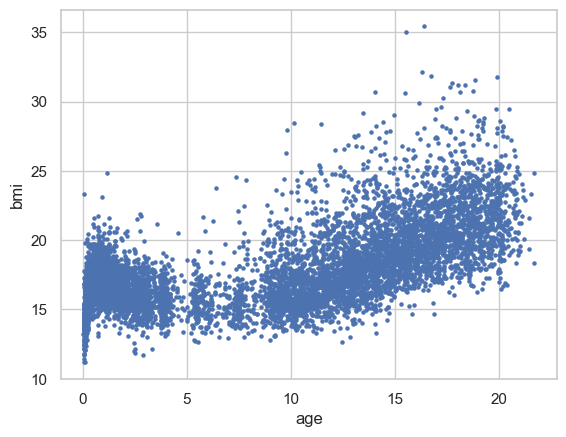

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=False)
X.smooth(data=df["age"].to_numpy())

# Set up hyperparameters for the beta_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=1.0, distribution=tau_dist, param_space="positive", name="tau")

# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(jnp.zeros(X.smooth_dim[0]), name="beta_smooth_loc")

# Define the penaly matrix from class Obs
pen = X.smooth_pen_mat[0]

# Set up parameters 
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=jnp.repeat(jnp.array([0.0]), X.smooth_dim[0]), distribution=beta_smooth_dist, name="beta_smooth")

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up the linear predictor 
lpred = tiger.Lpred(obs=X, beta_smooth=beta_smooth)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [4]:
m.log_prob

Array(-35680.945, dtype=float32)

In [5]:
m.log_prior 

Array(-23.420815, dtype=float32)

In [6]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [7]:
graph.logprob()

Array(-35680.945, dtype=float32)

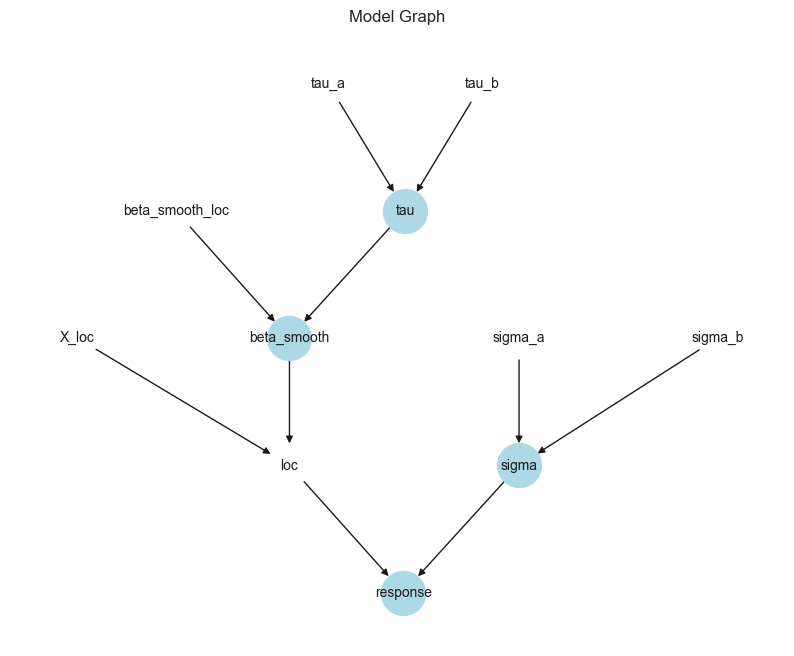

In [8]:
graph.visualize_graph()

## Test functions of Bbvi

In [34]:
test = {}
test["beta"] = jnp.ones((5,))
test = {}
test

{}

In [9]:
import tigerpy.distributions.mvn as mvn
q = bbvi.Bbvi(graph=graph)
key = jax.random.PRNGKey(27)

In [10]:
loc_beta_smooth, lower_tri_beta_smooth = q.init_variational_params["beta_smooth"]["loc"], q.init_variational_params["beta_smooth"]["lower_tri"]
loc_sigma, lower_tri_sigma = q.init_variational_params["sigma"]["loc"], q.init_variational_params["sigma"]["lower_tri"]
loc_tau, lower_tri_tau= q.init_variational_params["tau"]["loc"], q.init_variational_params["tau"]["lower_tri"]

In [11]:
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=key, S=64)
samples_sigma = mvn.mvn_precision_chol_sample(loc=loc_sigma, precision_matrix_chol=lower_tri_sigma, key=key, S=64)
samples_tau = mvn.mvn_precision_chol_sample(loc=loc_tau, precision_matrix_chol=lower_tri_tau, key=key, S=64)

In [12]:
test_samples = {"beta_smooth": samples_beta_smooth,
                "sigma": jnp.exp(samples_sigma),
                "tau": jnp.exp(samples_tau)}

In [13]:
batch_idx = jax.random.choice(key, q.num_obs, (32,), replace=False)

In [14]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [15]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Array(-296468.44, dtype=float32)

In [16]:
q.lower_bound(q.init_variational_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(157805.56, dtype=float32)

## Test why smoothing via mvn_degen is so weak !

In [23]:
loc, scale = graph.digraph.nodes["beta_smooth"]["input"]["loc"], graph.digraph.nodes["beta_smooth"]["input"]["scale"]

In [25]:
MultivariateNormalDegenerate(loc=loc, scale=scale, pen=pen)

<tfp.distributions.MultivariateNormalDegenerate 'MultivariateNormalDegenerate' batch_shape=[1] event_shape=[20] dtype=float64>

## Inference with Bbvi

In [22]:
q = bbvi.Bbvi(graph=graph)

In [18]:
import optax
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.,
    peak_value=0.2,
    warmup_steps=100,
    decay_steps=2_000,
    end_value=0.001,
)

In [ ]:
-14100.844

In [23]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=27,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=1000)

(Array(-14100.844, dtype=float32, weak_type=True),
 {'tau': {'loc': Array([-0.33559337], dtype=float32, weak_type=True),
   'cov': Array([[0.02748605]], dtype=float32)},
  'sigma': {'loc': Array([0.7262624], dtype=float32, weak_type=True),
   'cov': Array([[7.766186e-05]], dtype=float32)},
  'beta_smooth': {'loc': Array([17.125319, 15.86723 , 15.057533, 16.13032 , 15.803557, 15.669736,
          15.926813, 16.328257, 16.614578, 16.842022, 17.371155, 17.9138  ,
          18.450148, 19.14957 , 19.596087, 20.179482, 20.845255, 21.391546,
          21.699938, 21.97442 ], dtype=float32),
   'cov': Array([[ 1.55412604e-03,  2.21224246e-03,  9.98949865e-04,
           -3.39811272e-03, -3.20666324e-04,  2.73916754e-04,
            1.82129850e-04,  2.58042535e-04, -1.34394373e-04,
           -1.92411055e-04,  8.34148232e-05,  6.62648017e-05,
           -6.66919150e-05, -8.14598752e-05, -4.59388684e-05,
            1.20319877e-04, -1.91792657e-04, -5.94445664e-05,
            1.10508190e-05,  3.

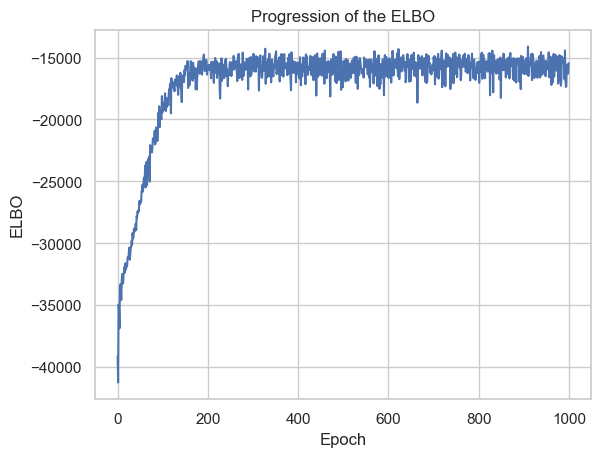

In [20]:
q.plot_elbo()

## Visualize the regression line 

In [17]:
b = q.trans_variational_params["beta_smooth"]["loc"]
b

Array([17.136692, 15.856349, 15.070966, 16.114622, 15.756129, 15.618155,
       15.909843, 16.330965, 16.619133, 16.854109, 17.408978, 17.90114 ,
       18.46926 , 19.12455 , 19.55921 , 20.17325 , 20.835325, 21.388105,
       21.709146, 21.945478], dtype=float32)

In [24]:
# plot the regression line 
b = q.trans_variational_params["beta_smooth"]["loc"]
x_new = jnp.linspace(df["age"].to_numpy().min(), df["age"].to_numpy().max(), num=100)
X_new = tiger.Obs(name="X_pred", intercept=False)
X_new.smooth(data = x_new)
y = X_new.design_matrix @ b

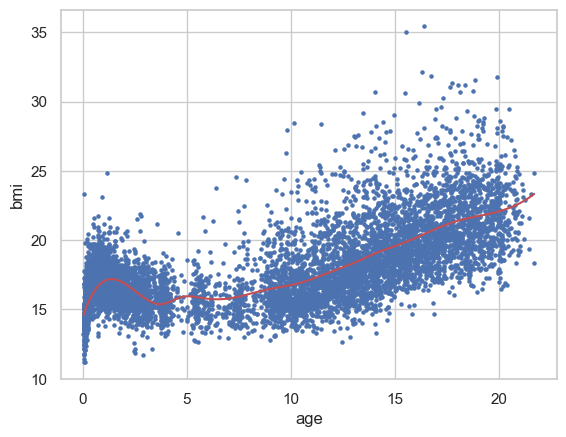

In [25]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(x_new, y, color = "r")
#ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [26]:
tau = q.trans_variational_params["tau"]["loc"]
s = q.trans_variational_params["tau"]["cov"]

In [27]:
tau, s

(Array([-0.33559337], dtype=float32, weak_type=True),
 Array([[0.02748605]], dtype=float32))

In [28]:
mean = jnp.exp(tau + s/2)
mean

Array([[0.72480667]], dtype=float32)

In [29]:
1 / (mean ** 2)

Array([[1.903512]], dtype=float32)

In [30]:
1 / (0.3 ** 2)

11.11111111111111